# Towards Interactive Datascience in Haskell #

## Introduction ##

Haskell and data science - on first sight a great match: native function
composition, lazy evaluation, fast execution times, and lots of code checks.
These sound like ingredients for scalable, production-ready data transformation
pipelines. What is missing then? Why is Haskell not widely used in data
science?

One of the reasons is that Haskell lacks a standardized data analysis
environment. For example, Python has a *de facto* standard library set with
`numpy`, `pandas` and `scikit-learn` that form the backbone, and many other
well-supported specialized libraries such as `keras` and `tensorflow` that are
easily accessible. These libraries are distributed with user friendly package
managers and explained in a plethora of tutorials, Stack Overflow questions and
millions of Jupyter notebooks. Most problems from beginner to advanced level
can be solved by adapting and combining these existing solutions.

This post presents Jupyter and JupyterLab - both important ingredients of the
Python ecosystem - and shows how we can take advantage of these tools for
interactive data analysis in Haskell.

## Jupyter and exploratory data analysis ##


[Project Jupyter](https://jupyter.org/) became famous through the browser-based
notebook app that allows to execute code in various compute environments and
interlace it with text and media elements
([example gallery](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)).

More generally, Project Jupyter standardizes the interactions between Jupyter
*frontends* such as the notebook and Jupyter *kernels*, the compute
environments. Typically a kernel receives a message from a frontend, executes
some code, and responds with a rich media message. The frontend can render the
response message as text, images, videos or small applications. All exchanged
messages are standardized by the Jupyter protocol and therefore independent of
the specific frontend or kernel that is used. Various frontends and kernels for
many different languages, like Python, Haskell, R, C++, Julia, etc, exist.

Quick REPL-like interaction of a user with a compute environment via a frontend
is very useful for exploratory data analysis. The user interrogates and
transforms the data with little code snippets and receives immediate feedback
through rich media responses. Different algorithms (expressed as short code
snippets) can rapidly be prototyped and visualized. Long multistep dialogues
with the kernel can be assembled into a sequential notebook. Notebooks
interlace explanatory text, code and media elements and can therefore be used
as human-readable reports (such as this blogpost). This workflow has become one
of the most popular ways for exploratory data analysis.


## Conversations with a Jupyter kernel ##

[IHaskell](https://github.com/gibiansky/IHaskell) is the name of the Jupyter
kernel for Haskell. It contains a little executable `ihaskell` that can receive
and respond to messages in the Jupyter protocoll (via
[ZeroMQ](http://zeromq.org/). Here is a little dialogue with `ihaskell` that is
initiated by sending the following code snippet from the notebook frontend to
`ihaskell`:

In [1]:
take 10 $ (^2) <$> [1..]

[1,4,9,16,25,36,49,64,81,100]

In Jupyter parlance the above dialogue corresponds to the following
`execute_request`:

```
        >> shell.execute_request (8be63d5c-1170-495d-82da-e56272052faf) <<

        header: {username: "", version: "5.2", session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9",
                 msg_id: "8be63d5c-1170-495d-82da-e56272052faf", msg_type: "execute_request"}
        parent_header: Object
        channel: "shell"
        content: {silent: false, store_history: true, user_expressions: Object, allow_stdin: true,
                  stop_on_error: true, code: "take 10 $ (^2) <$> [1..]"}   <<<<<<<<<<< LOOK HERE
        metadata: Object
        buffers: Array[0]
```

, and to the following `display_data` message that is received as a response:

```
        << iopub.display_data (68cce1e7-4d60-4a20-a707-4bf352c4d8d2) >>

        header: {username: "", msg_type: "display_data", version: "5.0"
                 msg_id: "68cce1e7-4d60-4a20-a707-4bf352c4d8d2",
                 session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9",
                 date: "2018-08-02T08:14:10.245877Z"}
        msg_id: "68cce1e7-4d60-4a20-a707-4bf352c4d8d2"
        msg_type: "display_data"
        parent_header: {username: "", msg_type: "execute_request", version: "5.0",
                        msg_id: "8be63d5c-1170-495d-82da-e56272052faf",
                        session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9"}
        metadata: Object
        content: {data: {text/plain: "[1,4,9,16,25,36,49,64,81,100]"},  <<<<<<<<<<< LOOK HERE
                  metadata: {output_type: "display_data"}}
        buffers: Array[0]
        channel: "iopub"
```

`ihaskell` can import Haskell libraries dynamically and has some special
commands to enable language extensions, print type information or to use
Hoogle.


## JupyterLab ##

JupyterLab is the newest animal in the Jupyter frontend zoo, and it is arguably
the most powerful: console, notebook, terminal, text-editor, or image viewer,
Jupyterlab integrates these data science building blocks into a single web
based user interface. Jupyterlab is setup as a modular system that can be
extended. A module assembles the base elements, changes or add new features to
build an IDE, a classical notebook or even a GUI where all interactions with
the underlying execution kernels are hidden behind graphical elements.

How can Haskell take advantage of Jupyterlab's capacities? To begin with,
JupyterLab provides plenty of out-of-the-box renderers that can be used for
free by Haskell. From the [default
renderers](https://jupyterlab.readthedocs.io/en/stable/user/file_formats.html),
the most interesting is probably Vega plotting. But also `geojson`, `plotly` or
and many other formats are available from the list of extensions, that will
certainly grow. Another use case might be to using the jupyterlab extension
system makes it easy to build a simple UI that interact with an execution
environment. Finally, Jupyter and associated workflows are known by a large
community. Using Haskell through these familiar environments softens the
barrier that many encounter when exploring Haskell for serious data science.

Let's get into a small example that shows how to use the Jupyterlab VEGA
renderer with IHaskell in Jupyterlab.

## Wordclouds using Haskell, Vega and Jupyterlab ##

We will use here the word content of a few wikipedia articles that are saved
as text files in the `./posts` folder. Here is a little code cell that reads all
`.txt` files in the `posts` folder and concatenates them in a single long string
from which we remove some punctuation characters. The code cell is sent to the
`ihaskell` kernel, which responds to the last `take` function with a simple text
response.

In [33]:
:ext QuasiQuotes
import System.Directory
import Data.List

fnames <- getDirectoryContents "./posts"
paths = ("./posts/"++) <$> fnames
md_files = filter (isSuffixOf ".txt") paths
text <- mconcat (readFile <$> md_files)
cleanedText = filter (not . (`elem` "\n,.?!-:;\"\'")) text
take 500 cleanedText

"The City of New York often called New York City (NYC) or simply New York (NY) is the most populous city in the United States[9] With an estimated 2017 population of 8622698[7] distributed over a land area of about 3026 square miles (784 km2)[10][11] New York City is also the most densely populated major city in the United States[12] Located at the southern tip of the state of New York the city is the center of the New York metropolitan area the largest metropolitan area in the world by urban lan"

Now let's define a Vega JSON as a string and fill it up with our text. A
convenient way to write longer multiline strings in Haskell are `QuasiQuotes`.
We use `fString` QuasiQuotes from the `PyF` package. Note that `{}` fills in
template data and `{{` corresponds to an escaped `{`.

In [34]:
import Formatting
import PyF
import Data.String.QQ

let vegaString = [fString|{{
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "width": 800,
  "height": 400,
  "padding": 0,

  "data": [
    {{
      "name": "table",
      "values": [
         "{cleanedText}"
      ],
      "transform": [
        {{
          "type": "countpattern",
          "field": "data",
          "case": "upper",
          "pattern": "[\\\\w']{{3,}}",
          "stopwords": "(\\\\d+|youll|looking|like|youre|etc|yet|need|cant|ALSO|STILL|ISNT|Want|Lots|HTTP|HTTPS|i|me|my|myself|we|us|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves|what|which|who|whom|whose|this|that|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|will|would|should|can|could|ought|i'm|you're|he's|she's|it's|we're|they're|i've|you've|we've|they've|i'd|you'd|he'd|she'd|we'd|they'd|i'll|you'll|he'll|she'll|we'll|they'll|isn't|aren't|wasn't|weren't|hasn't|haven't|hadn't|doesn't|don't|didn't|won't|wouldn't|shan't|shouldn't|can't|cannot|couldn't|mustn't|let's|that's|who's|what's|here's|there's|when's|where's|why's|how's|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|upon|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|say|says|said|shall)"
        }},
        {{
          "type": "formula", "as": "angle",
          "expr": "[0, 90][~~(random() * 3)]"
        }},
        {{
          "type": "formula", "as": "weight",
          "expr": "if(datum.text=='VEGA', 600, 300)"
        }}
      ]
    }}
  ],

  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "range": ["#3e4593", "#bc3761", "#39163d", "#2a1337"]
    }}
  ],

  "marks": [
    {{
      "type": "text",
      "from": {{"data": "table"}},
      "encode": {{
        "enter": {{
          "text": {{"field": "text"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "alphabetic"}},
          "fill": {{"scale": "color", "field": "text"}}
        }},
        "update": {{
          "fillOpacity": {{"value": 1}}
        }},
        "hover": {{
          "fillOpacity": {{"value": 0.5}}
        }}
      }},
      "transform": [
        {{
          "type": "wordcloud",
          "size": [800, 400],
          "text": {{"field": "text"}},
          "rotate": {{"field": "datum.angle"}},
          "font": "Helvetica Neue, Arial",
          "fontSize": {{"field": "datum.count"}},
          "fontWeight": {{"field": "datum.weight"}},
          "fontSizeRange": [12, 56],
          "padding": 2
        }}
      ]
    }}
  ]
}}|]

We display this JSON string with the native Jupyterlab JSON renderer here for
convenience. The `Display` function explicitly tells `ihaskell` to send a
display message to the frontend. The JSON function tells `ihaskell` to annotate
the content of the display message as `application/json`.

In [35]:
import qualified IHaskell.Display as D
D.Display [D.json vegaString]

Finally, we can plot this JSON with Vega:

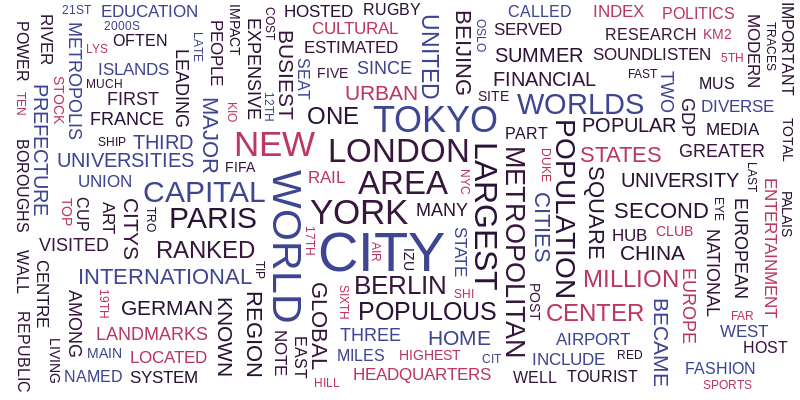

In [36]:
D.Display [D.vegalite vegaString]